### Desafío - Análisis lineal discriminante

**Luis Porras**

* Para poder realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.


#### Descripción
Trabajaremos con una base de datos sobre clientes morosos de un banco. Dentro de ésta se registran las siguientes observaciones:
* default : Variable Binaria. Registra si el cliente entró en morosidad o no.
* income : Ingreso promedio declarado por el cliente.
* balance : total del sando en la cuenta de crédito.
* student : Variable binaria. Registra si el cliente es estudiante o no.

### Ejercicio 1: Preparación de ambiente de trabajo
* Importe los módulos básicos para el análisis de datos.
* Importe las clases LabelEncoder , StandardScaler y LabelBinarizer de preprocessing
* Importe las funciones train_test_split y cross_val_score de model_selection
* Importe la función classification_report de metrics
* Importe las clases LinearDiscriminantAnalysis y QuadraticDiscriminantAnalysis .
* Agregue la base de datos en el ambiente de trabajo.
* Inspeccione la distribución de cada atributo

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import warnings
from sklearn.preprocessing import LabelEncoder, StandardScaler, LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

warnings.filterwarnings(action='ignore')

In [3]:
df = pd.read_csv('default_credit.csv')
df = df.drop('index', axis = 1)
df.head(5)

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


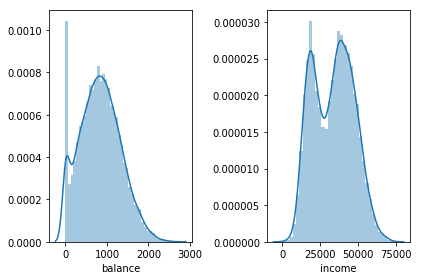

In [5]:
for n, col in enumerate(['balance', 'income']):
    plt.subplot(1, 2, n + 1)
    sns.distplot(df[col]);
    plt.tight_layout()

Podemos ver que:

- `balance` se parece a una normal.
- `income` es como si fueran dos normales.

### Ejercicio 2: Modelo base

* Recuerde que los modelos de sklearn no soportan datos que no sean numéricos. Transforme los atributos pertinentes con LabelEncoder .
* Genere muestras de validación y entrenamiento, reservando un 33% de los datos como validación.
* Genere un modelo con LinearDiscriminantAnalysis sin modificar los hiperparámetros.
* Genere métricas de evaluación utilizando classification_report .
* Comente sobre cuál es el desempeño del modelo en cada clase, así como en general.

Transformamos `default` y `student`:

In [6]:
label_encoder = LabelEncoder()

df['default'] = label_encoder.fit_transform(df['default'])
df['student'] = label_encoder.fit_transform(df['student'])

df.head(3)

,default,student,balance,income
0,0,0,729.526495,44361.625074
1,0,1,817.180407,12106.134700
2,0,0,1073.549164,31767.138947


Generamos muestras de validación y entrenamiento

In [7]:
y = df['default']
attrs = ['student', 'balance', 'income']

X = StandardScaler().fit_transform(df.loc[:, attrs])

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.33, random_state = 240008947)

In [8]:
def train_and_report(X_train, y_train, kind = 'LDA', priors = None):
    if kind == 'LDA':
        model = LinearDiscriminantAnalysis(priors=priors)
    else:
        model = QuadraticDiscriminantAnalysis(priors=priors)

    result = model.fit(X_train, y_train)
    y_hat = result.predict(X_test)
    print(classification_report(y_test, y_hat))

    cnf = confusion_matrix(y_test, y_hat) / len(y_test)
    labels = ['Moroso', 'No moroso']
    plt.title('Matriz de confusión')
    sns.heatmap(cnf, xticklabels=labels, yticklabels=labels, annot=True, fmt=".1%", cbar=False, cmap='Blues');

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3198
           1       0.79      0.22      0.34       102

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.88      0.61      0.66      3300
weighted avg       0.97      0.97      0.97      3300



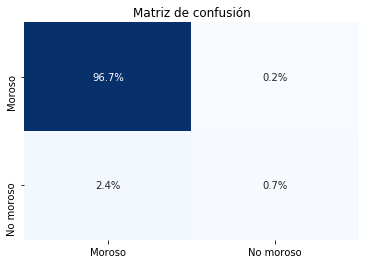

In [9]:
train_and_report(X_train, y_train)

#### Observaciones:

- El modelo clasifica muy bien la clase `default = 0` (no morosos)
- Para la clase `default = 1` hay problemas, ya que el `precision` es bueno pero el `recall` es muy bajo, lo que quiere decir que muchos clientes que son morosos realmente que fueron clasificados como no morosos.

Claramente hay un problema porque los clientes morosos son pocos (sólo el 3% de las observaciones).

### Ejercicio 3: Refactorización 1 - información a priori
* Dado que trabajamos con modelos generativos, podemos incluír información exógena. Para este caso agregaremos dos distribuciones:
    * Asumamos que hay un 50/50 de morosos y no morosos.
    * Asumamos que hay un 60/40 de morosos y no morosos.
* Por cada modelo, reporte las métricas de clasificación.

              precision    recall  f1-score   support

           0       1.00      0.84      0.91      3198
           1       0.16      0.91      0.27       102

   micro avg       0.85      0.85      0.85      3300
   macro avg       0.58      0.88      0.59      3300
weighted avg       0.97      0.85      0.89      3300



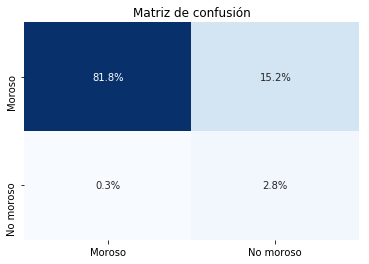

In [10]:
train_and_report(X_train, y_train, priors=[0.5, 0.5])

              precision    recall  f1-score   support

           0       1.00      0.79      0.88      3198
           1       0.12      0.93      0.22       102

   micro avg       0.80      0.80      0.80      3300
   macro avg       0.56      0.86      0.55      3300
weighted avg       0.97      0.80      0.86      3300



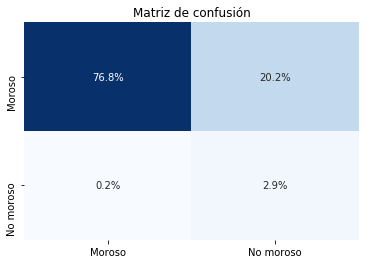

In [11]:
train_and_report(X_train, y_train, priors=[0.4, 0.6])

### Ejercicio 4: Refactorización 2 - oversampling
Digresión: Synthetic Over(Under)Sampling

* Por lo general podemos intentar aliviar el problema del desbalance de clases mediante la ponderación dentro del algoritmo. Otra alternativa es el muestreo con reemplazo dentro de los conjuntos de entrenamiento. Estos métodos clásicos se conocen como Oversampling cuando repetimos registros aleatorios de la clase minoritaria, y Undersampling cuando eliminamos aleatoriamente registros de la clase mayoritaria.
* Un contratiempo de estos métodos clásicos es que pueden replicar información sesgada que afecte el desempeño de generalización del modelo. Si los datos son malos, estaremos replicando estas fallas.
* Otra solución es generar ejemplos de entrenamiento sintéticos mediante el entrenamiento de ejemplos de la clase minoritaria. A grandes rasgos la solución funciona de la siguiente forma: 
    * En función a un subconjunto de datos correspondientes a la case minoritaria, entrenamos algún modelo no supervisado o generativo como Naive Bayes, KMeans o KNearestNeighbors para generar representaciones sintéticas de los datos en el espacio de atributos de la clase específica mediante 
    
    $\mathbf{x}_{nuevoEjemplo} = \mathbf{x}_{i} + \lambda (\mathbf{x}_{zi} - \mathbf{x}_{i})$ 
    
    donde 
    $\mathbf{x}_{zi}$ 
    es un ejemplo de entrenamiento de la clase minoritaria y $\lambda$ es un parámetro de interpolación aleatorio $\lambda \sim \textsf{Uniforme}(0, 1)$.
    
    
* Uno de los problemas más graves de esta base de datos, es el fuerte desbalance entre clases. Ahora generaremos observaciones sintéticas mediante SMOTE (Synthetic Minority Oversampling Technique). Para ello, debemos agregar el paquete a nuestro ambiente virtual. En nuestro terminal agregamos conda install -c conda-forge imbalanced-learn. Incorpore SMOTE en el ambiente de trabajo con la siguiente sintáxis from imblearn.over_sampling import SMOTE.

* Para implementar oversampling, debemos generar nuevos objetos que representan nuestra muestra de entrenamiento incrementada artificialmente. Para ello implemente la siguiente sintáxis:

```python
from imblearn.over_sampling import SMOTE
# Instanciamos la clase
oversampler = SMOTE(random_state=11238, ratio='minority')
# generamos el eversampling de la matriz de entrenamiento y
X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)
```

* Vuelva a entrenar el modelo con los datos aumentados de forma artificial y comente sobre su desempeño.

              precision    recall  f1-score   support

           0       1.00      0.85      0.91      3198
           1       0.16      0.91      0.27       102

   micro avg       0.85      0.85      0.85      3300
   macro avg       0.58      0.88      0.59      3300
weighted avg       0.97      0.85      0.89      3300



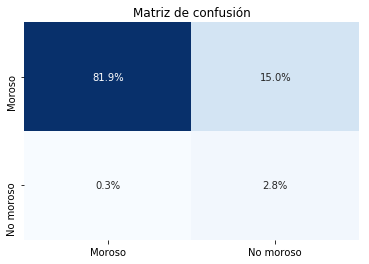

In [14]:
from imblearn.over_sampling import SMOTE

oversampler = SMOTE(random_state=240008947, ratio='minority')

X_train_oversamp, y_train_oversamp = oversampler.fit_sample(X_train, y_train)

train_and_report(X_train_oversamp, y_train_oversamp)

### Ejercicio 5: Refactorización 3 - QDA

* Por último, implemente un modelo QuadraticDiscriminantAnalysis con los datos aumentados artificialmente. Genere las métricas de desempeño.
* Comente a grandes rasgos sobre el mejor modelo en su capacidad predictiva.

              precision    recall  f1-score   support

           0       1.00      0.86      0.92      3198
           1       0.17      0.88      0.28       102

   micro avg       0.86      0.86      0.86      3300
   macro avg       0.58      0.87      0.60      3300
weighted avg       0.97      0.86      0.90      3300



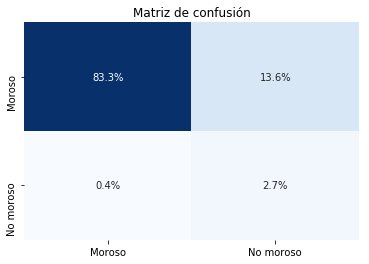

In [15]:
train_and_report(X_train_oversamp, y_train_oversamp, kind='QDA')

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3198
           1       0.74      0.25      0.38       102

   micro avg       0.97      0.97      0.97      3300
   macro avg       0.86      0.63      0.68      3300
weighted avg       0.97      0.97      0.97      3300



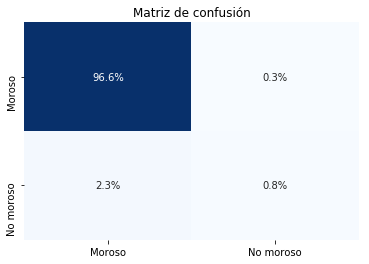

In [16]:
train_and_report(X_train, y_train, kind='QDA')

#### Observaciones

- El mejor modelo es el" Modelo Base" (el primero) ya que tiene un `f1-score` de 0.39. Le siguen:

    1. QDA con oversampling (`f1-score = 0.28`)
    2. LDA con priori 50/50 y LDA con oversampling (`f1-score = 0.27`)
    3. LDA con priori 60/40 (`f1-score = 0.25`)

- Se ve que hay un trade-off entre precision y recall para la predicción de "moroso" en los modelos refactorizados que implementados. En todos, el precisión disminuyó muchísimo y el recall aumento. En estos casos los modelos piensan que muchos sujetos son morosos, incluso aquellos que no lo son.